In [1]:
#This is the code to test and train the XGBoost model using the Kaggle dataset(https://www.kaggle.com/datasets/sajid576/sql-injection-dataset) and to find the confusion matrix for the model
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import re
import sklearn
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import sparse

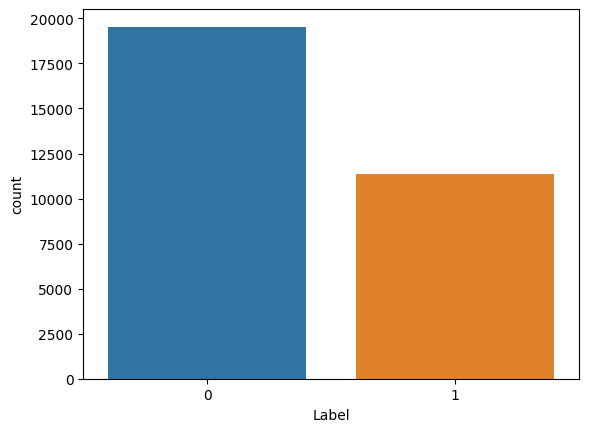

In [2]:
#Read and analyze the dataset
dataset = pd.read_csv("Modified_SQL_Dataset.csv")
dataset.shape
sns.countplot(x='Label',data=dataset)
plt.show()

In [3]:
#split the dataset into train and test
Y = dataset['Label']
X = dataset.drop('Label',axis = 1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,stratify = Y)

X_train['label'] = Y_train
X_test['label'] = Y_test

print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)
print("Y_train shape :",Y_train.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : (20715, 2)
X_test shape : (10204, 2)
Y_train shape : (20715,)
Y_test shape : (10204,)


In [4]:
X_train.to_csv("train.csv", index=False)
X_test.to_csv("test.csv", index=False)

In [5]:
X_train  = pd.read_csv("train.csv")
X_test  = pd.read_csv("test.csv")
print(X_test)
print(X_test.shape)
print(X_train.shape)

                                                   Query  label
0             SELECT * FROM becoming ORDER BY chain DESC      0
1      1'   )    )     )   or 4915  =    (  select co...      1
2      -5698'   )    )    as egjr where 5586  =  5586...      1
3                            1'  )   where 1212  =  1212      1
4      SELECT * FROM age FETCH FIRST 50 PERCENT ROWS ...      0
...                                                  ...    ...
10199  call regexp_substring  (  repeat  (  right  ( ...      1
10200                                              34473      0
10201  SELECT option_value FROM wp_options WHERE opti...      0
10202  1%'  )   and 8312  =  dbms_pipe.receive_messag...      1
10203                                        SELECT drop      0

[10204 rows x 2 columns]
(10204, 2)
(20715, 2)


In [6]:
# Preprocessing data
# Conversion to lower case
def convert_To_Lower_case(x):
    return x.lower()

In [7]:
# Removal of duplicates
def preprocess(data):
    data['Query'] = data['Query'].apply(convert_To_Lower_case)
    boolean = data.duplicated(subset = ['Query','label'])
    data.drop_duplicates(subset = ['Query','label'],inplace = True)
    #dropping the few queries which has both the label to avoid ambiguity
    data.drop_duplicates(subset = ['Query'],keep = False,inplace = True)
    return data

In [8]:
X_train = preprocess(X_train)
X_train.shape

(20704, 2)

In [9]:
X_test = preprocess(X_test)
X_test.shape

(10200, 2)

In [10]:
# Creating all the features
def number_of_single_quotations(x):
    list_single_quotes = re.findall("'",x)
    return len(list_single_quotes)

def number_of_double_quotations(x):
    list_double_quotes = re.findall("\"",x)
    return len(list_double_quotes)

def number_of_hash(x):
    list_hash = re.findall("#",x)
    return len(list_hash)

def number_of_dollar(x):
    list_dollar = re.findall("\$",x)
    return len(list_dollar)

def number_of_paranthesis(x):
    list_paranthesis = re.findall("\(|\)",x)
    return len(list_paranthesis)

def number_of_square_brackets(x):
    list_square_brackets = re.findall("\[|\]",x)
    return len(list_square_brackets)

def number_of_at_symbol(x):
    list_at_symbol = re.findall("@",x)
    return len(list_at_symbol)

def number_of_colon(x):
    list_colon = re.findall(":",x)
    return len(list_colon)

def number_of_semicolon(x):
    list_semicolon = re.findall(";",x)
    return len(list_semicolon)

def number_of_equals(x):
    list_equals = re.findall("=",x)
    return len(list_equals)

def number_of_angular_brackets(x):
    list_angular_brackets = re.findall("<|>",x)
    return len(list_angular_brackets)

def number_of_question_mark(x):
    list_question_mark = re.findall("\?",x)
    return len(list_question_mark)

def number_of_under_score(x):
    list_under_score = re.findall("\_",x)
    return len(list_under_score)

def number_of_arithematic(x):
    list_arithematic = re.findall("\+|-|[^\/]\*|\/[^\*]",x)
    return len(list_arithematic)

def number_of_comma(x):
    list_comma = re.findall(",",x)
    return len(list_comma)

def number_of_dot(x):
    list_dot = re.findall("\.",x)
    return len(list_dot)

def number_of_single_comment(x):
    list_single_comment = re.findall("(--)",x)
    return len(list_single_comment)

def number_of_white_space(x):
    list_white_space = re.findall("\s+",x)
    return len(list_white_space)

def number_of_percentage(x):
    list_percentage = re.findall("%",x)
    return len(list_percentage)

def number_of_logical_operators(x):
    list_logical_operators = re.findall("\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!",x)
    return len(list_logical_operators)

def number_of_punctuation(x):
    list_punctuation = re.findall("[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]",x)
    return len(list_punctuation)

def number_of_hexadecimal(x):
    list_hexadecimal = re.findall("0[xX][0-9a-fA-F]+\s",x)
    return len(list_hexadecimal)

def number_of_null(x):
    list_null = re.findall("null",x)
    return len(list_null)

def number_of_digits(x):
    list_digits = re.findall("[0-9]",x)
    return len(list_digits)

def number_of_alphabets(x):
    list_alphabets = re.findall("[a-zA-Z]",x)
    return len(list_alphabets)
    
def number_of_keywords(x):
    keywords = ['select', 'insert', 'update', 'delete', 'from', 'where', 'join', 'on', 'group by', 'order by', 'having']
    return sum([1 for kw in keywords if kw in x])
    
def number_of_tables(x):
    tables = re.findall(r'\bfrom\b\s+(\w+)', x)
    return len(tables)
    
def number_of_wheres(x):
    wheres = re.findall(r'\bwhere\b', x)
    return len(wheres)
    
def number_of_ors(x):
    ors = re.findall(r'\bor\b', x)
    return len(ors)
    
def number_of_unions(x):
    unions = re.findall(r'\bunion\b', x)
    return len(unions)
    
def number_of_subqueries(x):
    subqueries = re.findall(r'\bselect\b.*?\bfrom\b', x, re.DOTALL)
    return len(subqueries)
    
def number_of_joins(x):
    joins = re.findall(r'\bjoin\b', x)
    return len(joins)
    

def create_features(data):
    data['number_single_quotes'] = data.Query.apply(number_of_single_quotations)
    data['number_double_quotes'] = data.Query.apply(number_of_double_quotations) 
    data['number_hash'] = data.Query.apply(number_of_hash) 
    data['number_dollar'] = data.Query.apply(number_of_dollar)
    data['number_paranthesis'] = data.Query.apply(number_of_paranthesis)
    data['number_square_brackets'] = data.Query.apply(number_of_square_brackets)
    data['number_at_symbol'] = data.Query.apply(number_of_at_symbol)
    data['number_colon'] = data.Query.apply(number_of_colon)
    data['number_semicolon'] = data.Query.apply(number_of_semicolon)
    data['number_equals'] = data.Query.apply(number_of_equals)
    data['number_angular_brackets'] = data.Query.apply(number_of_angular_brackets)
    data['number_question_mark'] = data.Query.apply(number_of_question_mark)
    data['number_under_score'] = data.Query.apply(number_of_under_score)
    data['number_arithematic'] = data.Query.apply(number_of_arithematic)
    data['number_comma'] = data.Query.apply(number_of_comma)
    data['number_dot'] = data.Query.apply(number_of_dot)
    data['number_single_comment'] = data.Query.apply(number_of_single_comment)
    data['number_white_space'] = data.Query.apply(number_of_white_space) 
    data['number_percentage'] = data.Query.apply(number_of_percentage) 
    data['number_logical_operators'] = data.Query.apply(number_of_logical_operators) 
    data['number_punctuation'] = data.Query.apply(number_of_punctuation)
    data['number_hexadecimal'] = data.Query.apply(number_of_hexadecimal)
    data['number_null'] = data.Query.apply(number_of_null)
    data['number_digits'] = data.Query.apply(number_of_digits)
    data['number_alphabets'] = data.Query.apply(number_of_alphabets)
    data['number_keywords'] = data.Query.apply(number_of_keywords)
    data['number_tables'] = data.Query.apply(number_of_tables)
    data['number_wheres'] = data.Query.apply(number_of_wheres)
    data['number_ors'] = data.Query.apply(number_of_ors)
    data['number_unions'] = data.Query.apply(number_of_unions)
    data['number_subqueries'] = data.Query.apply(number_of_subqueries)
    data['number_joins'] = data.Query.apply(number_of_joins)
    return data

In [11]:
#Feature extraction for training dataset
X_train = create_features(X_train)
X_train.shape

(20704, 34)

In [12]:
X_train.head()

,Query,label,number_single_quotes,number_double_quotes,number_hash,number_dollar,number_paranthesis,number_square_brackets,number_at_symbol,number_colon,...,number_null,number_digits,number_alphabets,number_keywords,number_tables,number_wheres,number_ors,number_unions,number_subqueries,number_joins
0,or a = a--,1,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,1,0,0,0
1,"1"" where 2204 = 2204 and 3715 in ( ( ...",1,0,1,0,0,34,0,0,0,...,0,55,83,2,0,1,0,0,0,0
2,moriyama,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0
3,"1"" rlike sleep ( 5 )",1,0,1,0,0,2,0,0,0,...,0,2,10,0,0,0,0,0,0,0
4,or sleep ( __time__ ) = ',1,1,0,0,0,2,0,0,0,...,0,0,11,0,0,0,1,0,0,0


In [13]:
#Feature exrtaction for testing dataset
X_test = create_features(X_test)
X_test.shape
X_test.head()

,Query,label,number_single_quotes,number_double_quotes,number_hash,number_dollar,number_paranthesis,number_square_brackets,number_at_symbol,number_colon,...,number_null,number_digits,number_alphabets,number_keywords,number_tables,number_wheres,number_ors,number_unions,number_subqueries,number_joins
0,select * from becoming order by chain desc,0,0,0,0,0,0,0,0,0,...,0,0,34,3,1,0,0,0,1,0
1,1' ) ) ) or 4915 = ( select co...,1,1,0,0,0,7,0,0,0,...,0,8,64,2,1,0,1,0,1,0
2,-5698' ) ) as egjr where 5586 = 5586...,1,1,0,0,0,2,0,0,0,...,0,24,25,3,0,1,0,1,0,0
3,1' ) where 1212 = 1212,1,1,0,0,0,1,0,0,0,...,0,9,5,1,0,1,0,0,0,0
4,select * from age fetch first 50 percent rows ...,0,0,0,0,0,0,0,0,0,...,0,2,38,3,1,0,0,0,1,0


In [14]:
# Saving the file with new features

X_train.to_csv("Preprocessed_X_train.csv",index = False)
X_test.to_csv("Preprocessed_X_test.csv",index = False)

In [15]:
# Load the saved file

X_train = pd.read_csv("Preprocessed_X_train.csv")
X_test = pd.read_csv("Preprocessed_X_test.csv")

In [16]:
Y_train = X_train['label']
X_train = X_train.drop(['label'],axis = 1)
Y_test = X_test['label']
X_test = X_test.drop(['label'],axis = 1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20704, 33)
(10200, 33)
(20704,)
(10200,)


In [17]:
# Creating BoW for query column

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2),max_features = 50000)
X = vectorizer.fit(X_train['Query'])
X_train_query = X.transform(X_train['Query'])
X_test_query = X.transform(X_test['Query'])
print(X_test_query)
len(X.vocabulary_)

  (0, 16587)	1
  (0, 16879)	1
  (0, 17136)	1
  (0, 17842)	1
  (0, 18742)	1
  (0, 18866)	1
  (0, 28666)	1
  (0, 28667)	1
  (0, 34100)	1
  (0, 35604)	1
  (1, 4968)	1
  (1, 4969)	1
  (1, 13844)	3
  (1, 15077)	1
  (1, 15078)	1
  (1, 15079)	1
  (1, 17407)	1
  (1, 17408)	1
  (1, 17549)	1
  (1, 17561)	1
  (1, 17984)	3
  (1, 17985)	1
  (1, 17986)	1
  (1, 17987)	1
  (1, 17988)	1
  :	:
  (10197, 47569)	1
  (10197, 48728)	1
  (10197, 48731)	1
  (10198, 383)	1
  (10198, 386)	1
  (10198, 7306)	1
  (10198, 7359)	1
  (10198, 7361)	1
  (10198, 7891)	1
  (10198, 7893)	1
  (10198, 8124)	1
  (10198, 8125)	1
  (10198, 11277)	1
  (10198, 11583)	1
  (10198, 17240)	4
  (10198, 17241)	1
  (10198, 17257)	1
  (10198, 17258)	1
  (10198, 17261)	1
  (10198, 17777)	1
  (10198, 17778)	1
  (10198, 32306)	1
  (10198, 32307)	1
  (10199, 18044)	1
  (10199, 34100)	1


50000

In [18]:
X_train = X_train.drop(['Query'],axis =1 )
X_test = X_test.drop(['Query'],axis =1 )

In [19]:
X_train.head(5)

,number_single_quotes,number_double_quotes,number_hash,number_dollar,number_paranthesis,number_square_brackets,number_at_symbol,number_colon,number_semicolon,number_equals,...,number_null,number_digits,number_alphabets,number_keywords,number_tables,number_wheres,number_ors,number_unions,number_subqueries,number_joins
0,0,0,0,0,0,0,0,0,0,1,...,0,0,4,0,0,0,1,0,0,0
1,0,1,0,0,34,0,0,0,0,2,...,0,55,83,2,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0
3,0,1,0,0,2,0,0,0,0,0,...,0,2,10,0,0,0,0,0,0,0
4,1,0,0,0,2,0,0,0,0,1,...,0,0,11,0,0,0,1,0,0,0


In [20]:
X_test.head(5)

,number_single_quotes,number_double_quotes,number_hash,number_dollar,number_paranthesis,number_square_brackets,number_at_symbol,number_colon,number_semicolon,number_equals,...,number_null,number_digits,number_alphabets,number_keywords,number_tables,number_wheres,number_ors,number_unions,number_subqueries,number_joins
0,0,0,0,0,0,0,0,0,0,0,...,0,0,34,3,1,0,0,0,1,0
1,1,0,0,0,7,0,0,0,0,1,...,0,8,64,2,1,0,1,0,1,0
2,1,0,0,0,2,0,0,0,0,1,...,0,24,25,3,0,1,0,1,0,0
3,1,0,0,0,1,0,0,0,0,1,...,0,9,5,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,2,38,3,1,0,0,0,1,0


In [21]:
X_train = hstack((X_train,X_train_query)).tocsr()
X_test = hstack((X_test,X_test_query)).tocsr()

In [22]:
X_train.shape

(20704, 50032)

In [23]:
X_test.shape

(10200, 50032)

In [24]:
print(X_test)

  (0, 13)	1
  (0, 17)	7
  (0, 20)	1
  (0, 24)	34
  (0, 25)	3
  (0, 26)	1
  (0, 30)	1
  (0, 16619)	1
  (0, 16911)	1
  (0, 17168)	1
  (0, 17874)	1
  (0, 18774)	1
  (0, 18898)	1
  (0, 28698)	1
  (0, 28699)	1
  (0, 34132)	1
  (0, 35636)	1
  (1, 0)	1
  (1, 4)	7
  (1, 9)	1
  (1, 13)	3
  (1, 14)	2
  (1, 15)	3
  (1, 16)	1
  (1, 17)	22
  :	:
  (10198, 415)	1
  (10198, 418)	1
  (10198, 7338)	1
  (10198, 7391)	1
  (10198, 7393)	1
  (10198, 7923)	1
  (10198, 7925)	1
  (10198, 8156)	1
  (10198, 8157)	1
  (10198, 11309)	1
  (10198, 11615)	1
  (10198, 17272)	4
  (10198, 17273)	1
  (10198, 17289)	1
  (10198, 17290)	1
  (10198, 17293)	1
  (10198, 17809)	1
  (10198, 17810)	1
  (10198, 32338)	1
  (10198, 32339)	1
  (10199, 17)	1
  (10199, 24)	10
  (10199, 25)	1
  (10199, 18076)	1
  (10199, 34132)	1


In [25]:
def find_best_GBDT_classifier(X_train,Y_train,params):
    classifier = xgb.XGBClassifier()
    classifierGridSearch = RandomizedSearchCV(classifier,params,n_jobs=-1,cv =3,scoring = 'roc_auc',return_train_score=True)
    result_RS = classifierGridSearch.fit(X_train,Y_train)
    result = pd.DataFrame.from_dict(result_RS.cv_results_)
    return result,classifierGridSearch.best_params_

In [26]:
params = {'n_estimators':[5,10,50,75,100],'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}
cv_results_set_1,best_params_set_1 = find_best_GBDT_classifier(X_train,Y_train,params)
print("Best Found Parameters:\t",best_params_set_1)

Best Found Parameters:	 {'n_estimators': 75, 'learning_rate': 0.1}


In [27]:
def plot_XGBoost_results(Result):
    params = Result['params'].map(lambda x : str(x['n_estimators'])+","+str(x['learning_rate']))
    Train_auc = Result['mean_train_score']
    CV_auc = Result['mean_test_score']
    plt.plot(params, Train_auc, label=' kernel Train AUC')
    plt.plot(params, CV_auc, label=' kernel CV AUC')
    plt.scatter(params, Train_auc, label='kernel Train AUC points')
    plt.scatter(params, CV_auc, label='kernel CV AUC points')

    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Hyper parameter Vs AUC plot(Train-CV Data)")
    plt.grid()
    plt.show()

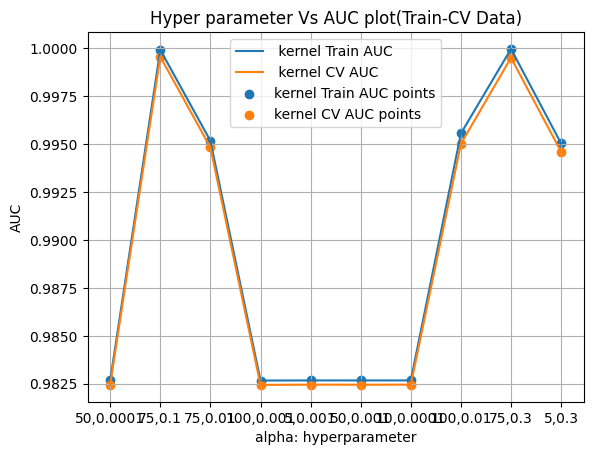

In [28]:
plot_XGBoost_results(cv_results_set_1)

In [29]:
# Training the model with the best n_estimators and learning_rate

classifier = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1)
classifier.fit(X_train,Y_train)
prediction = classifier.predict(X_test)

In [30]:
def display_confusion_matrix(CM):
    sns.heatmap(CM, annot=True,fmt="d",cmap='Blues',xticklabels = ['No','Yes'],yticklabels=['No','Yes'])
def get_F_1_Score(CM):
    TP = CM[1][1]
    TN = CM[0][0]
    FP = CM[1][0]
    FN = CM[0][1]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = (2*precision*recall)/(precision+recall)
    return f1_score

In [31]:
print(X_test)

  (0, 13)	1
  (0, 17)	7
  (0, 20)	1
  (0, 24)	34
  (0, 25)	3
  (0, 26)	1
  (0, 30)	1
  (0, 16619)	1
  (0, 16911)	1
  (0, 17168)	1
  (0, 17874)	1
  (0, 18774)	1
  (0, 18898)	1
  (0, 28698)	1
  (0, 28699)	1
  (0, 34132)	1
  (0, 35636)	1
  (1, 0)	1
  (1, 4)	7
  (1, 9)	1
  (1, 13)	3
  (1, 14)	2
  (1, 15)	3
  (1, 16)	1
  (1, 17)	22
  :	:
  (10198, 415)	1
  (10198, 418)	1
  (10198, 7338)	1
  (10198, 7391)	1
  (10198, 7393)	1
  (10198, 7923)	1
  (10198, 7925)	1
  (10198, 8156)	1
  (10198, 8157)	1
  (10198, 11309)	1
  (10198, 11615)	1
  (10198, 17272)	4
  (10198, 17273)	1
  (10198, 17289)	1
  (10198, 17290)	1
  (10198, 17293)	1
  (10198, 17809)	1
  (10198, 17810)	1
  (10198, 32338)	1
  (10198, 32339)	1
  (10199, 17)	1
  (10199, 24)	10
  (10199, 25)	1
  (10199, 18076)	1
  (10199, 34132)	1


In [32]:
# Generating Confusion Matrix

confusionMatrix = confusion_matrix(Y_test,classifier.predict(X_test))

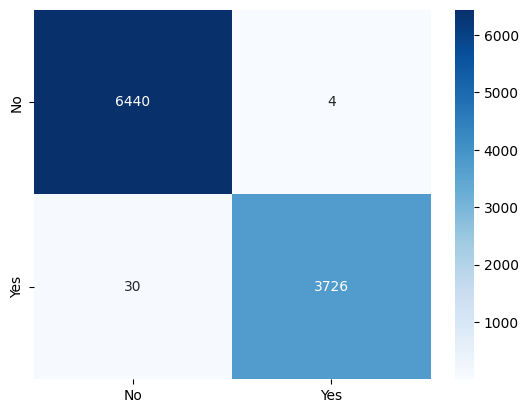

In [33]:
display_confusion_matrix(confusionMatrix)

In [34]:
print(get_F_1_Score(confusionMatrix))

0.9954581886187549


In [35]:
#Remove the temporary files
os.remove("Preprocessed_X_test.csv")
os.remove("Preprocessed_X_train.csv")
os.remove("test.csv")